In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import re
import numpy as np

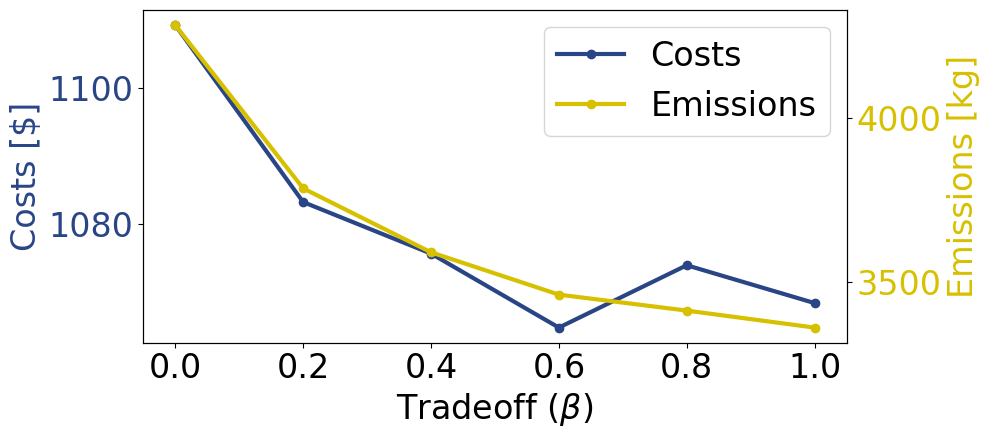

In [10]:
def load_cost_files_to_df(directory):
    # Load all CSV files from the specified directory that have 'cost' in their file name
    all_files = glob.glob(os.path.join(directory, "*tradeoff*.csv"))

    # Initialize an empty list to store individual dataframes
    data = []
    
    for file in all_files:
        df = pd.read_csv(file)
        emissions = df["Total Emissions"].mean().round(2)
        emissions_std = df.groupby("Building")["Total Emissions"].std().mean()

        profit = df["Total Profit"].mean().round(2)
        profit_std = df.groupby("Building")["Total Profit"].std().mean()

        file_prefix = os.path.basename(file).split('_')[0]

        tradeoff = re.search(r'Beta(\d+)', file)
        if tradeoff:
            tradeoff = tradeoff.group(1)
            if tradeoff == '1':
                tradeoff = '1.0'
            elif tradeoff == '0':
                tradeoff = '0.0'
            else:
                tradeoff = f'{int(tradeoff) / 10:.1f}'
        
        else:
            noise_scale = 'unknown'

        # Append the processed data
        data.append({
            'File Prefix': file_prefix,
            'Tradeoff': tradeoff,
            'Profit': profit,
            'Profit Std': profit_std,
            'Emissions': emissions,
            'Emissions Std': emissions_std
        })
    
    data = pd.DataFrame(data)
    return data

def plot_mean_profit_and_emissions_per_tradeoff(combined_df):

    # Calculate mean profit and emissions per tradeoff
    mean_profit_per_tradeoff = -combined_df.groupby('Tradeoff')['Profit'].mean()
    mean_emissions_per_tradeoff = combined_df.groupby('Tradeoff')['Emissions'].mean()

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 4.5))

    # Plotting Mean Profit
    color = '#294586'
    ax1.set_xlabel(r'Tradeoff ($\beta$)', fontsize=font_size_labels)
    ax1.set_ylabel('Costs [$]', fontsize=font_size_labels, color=color)
    ax1.plot(mean_profit_per_tradeoff.index, mean_profit_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Costs')
    ax1.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)
    ax1.tick_params(axis='x', labelsize=font_size_ticks)
    #ax1.grid(True)

    # Creating a second y-axis for Mean Emissions
    ax2 = ax1.twinx()
    color = '#D7C000'
    ax2.set_ylabel('Emissions [kg]', fontsize=font_size_labels, color=color)
    ax2.plot(mean_emissions_per_tradeoff.index, mean_emissions_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Emissions')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)

    # Adding legends
    fig.tight_layout()  # Adjust the layout to make room for the second y-axis
    #ax1.legend(loc='upper left', fontsize=font_size_legend)
    #ax2.legend(loc='upper right', fontsize=font_size_legend)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper right', fontsize=font_size_legend)

    # Save plot
    #plt.savefig('fig/Emission_profit_tradeoff.pdf', format='pdf', bbox_inches='tight')
    plt.show()


directory = r"results/05tradeoff"
combined_df = load_cost_files_to_df(directory)

# Plot the mean profit per tradeoff
plot_mean_profit_and_emissions_per_tradeoff(combined_df)

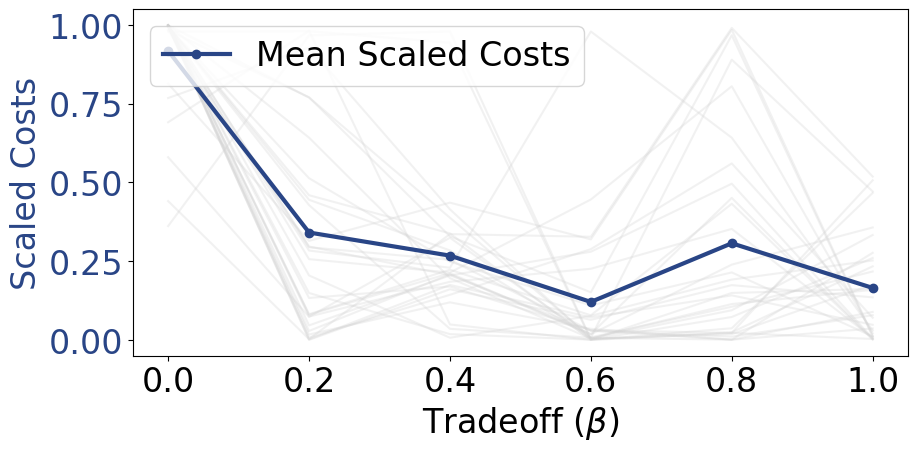

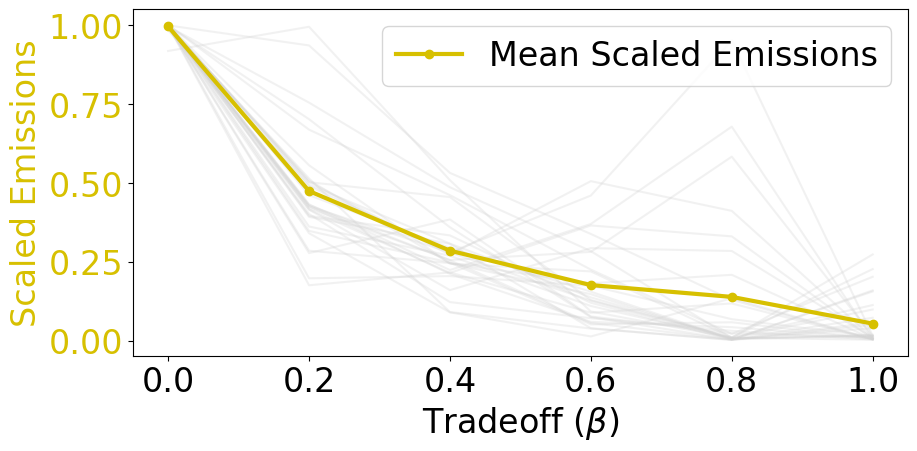

In [110]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re

def load_cost_files_to_df(directory):
    # Load all CSV files from the specified directory that have 'tradeoff' in their file name
    all_files = glob.glob(os.path.join(directory, "*tradeoff*.csv"))

    # Initialize an empty list to store individual dataframes
    data = []
    
    for file in all_files:
        df = pd.read_csv(file)
        file_prefix = os.path.basename(file).split('_')[0]

        tradeoff = re.search(r'Beta(\d+)', file)
        if tradeoff:
            tradeoff = tradeoff.group(1)
            if tradeoff == '1':
                tradeoff = '1.0'
            elif tradeoff == '0':
                tradeoff = '0.0'
            else:
                tradeoff = f'{int(tradeoff) / 10:.1f}'
        else:
            tradeoff = 'unknown'

        df['File Prefix'] = file_prefix
        df['Tradeoff'] = tradeoff

        # Append the processed data
        data.append(df)
    
    combined_df = pd.concat(data)
    
    # Min-max scaling for each building separately
    combined_df['Scaled Profit'] = combined_df.groupby('Building')['Total Profit'].transform(lambda x: (x.max() - x) / (x.max() - x.min()))
    combined_df['Scaled Emissions'] = combined_df.groupby('Building')['Total Emissions'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    return combined_df

def plot_mean_profit_and_emissions_per_tradeoff(combined_df):
    # Calculate mean profit and emissions per tradeoff
    mean_profit_per_tradeoff = combined_df.groupby('Tradeoff')['Scaled Profit'].mean()
    mean_emissions_per_tradeoff = combined_df.groupby('Tradeoff')['Scaled Emissions'].mean()

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24




    # Plotting Profit
    fig, ax1 = plt.subplots(figsize=(10, 4.5))
    color = '#294586'
    
    ax1.set_xlabel(r'Tradeoff ($\beta$)', fontsize=font_size_labels)
    ax1.set_ylabel('Scaled Costs', fontsize=font_size_labels, color=color)

    # Plot individual building profits
    for name, group in combined_df.groupby('Building'):
        grouped_profit = group.groupby('Tradeoff')['Scaled Profit'].mean()
        ax1.plot(grouped_profit.index, grouped_profit.values, color='lightgrey', linewidth=1.5, alpha=0.3)

    # Plot mean profit
    ax1.plot(
        mean_profit_per_tradeoff.index, 
        mean_profit_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Mean Scaled Costs')
    ax1.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)
    ax1.tick_params(axis='x', labelsize=font_size_ticks)

    ax1.legend(loc='upper left', fontsize=font_size_legend)
    
    # Save plot
    #plt.savefig('fig/Scaled_Profit_tradeoff.pdf', format='pdf', bbox_inches='tight')
    plt.show()









    # Plotting Emissions
    fig, ax2 = plt.subplots(figsize=(10, 4.5))
    color = '#D7C000'
    
    ax2.set_xlabel(r'Tradeoff ($\beta$)', fontsize=font_size_labels)
    ax2.set_ylabel('Scaled Emissions', fontsize=font_size_labels, color=color)

    # Plot individual building emissions
    for name, group in combined_df.groupby('Building'):
        grouped_emissions = group.groupby('Tradeoff')['Scaled Emissions'].mean()
        ax2.plot(grouped_emissions.index, grouped_emissions.values, color='lightgrey', linewidth=1.5, alpha=0.3)

    # Plot mean emissions
    ax2.plot(
        mean_emissions_per_tradeoff.index, 
        mean_emissions_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Mean Scaled Emissions')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)
    ax2.tick_params(axis='x', labelsize=font_size_ticks)

    ax2.legend(loc='upper right', fontsize=font_size_legend)

    # Save plot
    #plt.savefig('fig/Scaled_Emissions_tradeoff.pdf', format='pdf', bbox_inches='tight')
    plt.show()

directory = r"results/05tradeoff"
combined_df = load_cost_files_to_df(directory)

# Plot the mean profit and emissions per tradeoff
plot_mean_profit_and_emissions_per_tradeoff(combined_df)


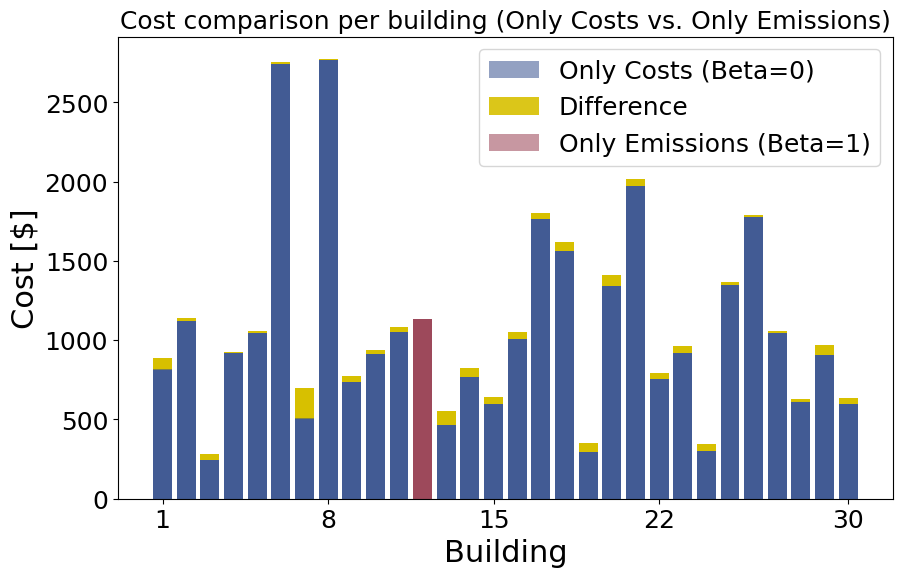

In [13]:
def load_cost_files_to_df():
    onlycosts = pd.read_csv("results/05tradeoff/FL_DDPG_TRADEOFF_Beta0.csv")
    onlyemissions = pd.read_csv("results/05tradeoff/FL_DDPG_TRADEOFF_Beta1.csv")

    data = pd.DataFrame()
    data[["Building", "Costs0"]] = onlycosts[["Building", "Total Profit"]]
    data["Costs0"] = -data["Costs0"]
    data["Costs1"] = -onlyemissions["Total Profit"]

    return data


combined_df = load_cost_files_to_df()
#display(combined_df[40:60])

# Determine the smaller and larger costs for each building
combined_df["Smaller"] = combined_df[["Costs0", "Costs1"]].min(axis=1)
combined_df["Difference"] = combined_df[["Costs0", "Costs1"]].max(axis=1) - combined_df["Smaller"]

# Determine which cost is higher
combined_df["HigherCost"] = combined_df.apply(lambda row: 'Costs0' if row["Costs0"] > row["Costs1"] else 'Costs1', axis=1)

# Plotting
buildings = combined_df["Building"]
smaller = combined_df["Smaller"]
difference = combined_df["Difference"]

#Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize labels to avoid duplication in the legend
costs_label = 'Only Costs (Beta=0)'
emissions_label = 'Only Emissions (Beta=1)'
difference_label = 'Difference'

for idx, row in combined_df.iterrows():
    if row["HigherCost"] == 'Costs0':
        color = '#294586'
        label = costs_label
        costs_label = None  # Prevents duplicate label in legend
    else:
        color = '#903045'
        label = emissions_label
        emissions_label = None  # Prevents duplicate label in legend

    # Plot the bars with appropriate color and label
    ax.bar(row["Building"], row["Smaller"], color=color, alpha=0.5, label=label)
    ax.bar(row["Building"], row["Difference"], bottom=row["Smaller"], color='#D7C000', alpha=0.9, label=difference_label if idx == 0 else "")
    difference_label = None  # Prevents duplicate label in legend

# Setting the x-ticks with font size
ax.set_xticks(np.linspace(1, 30, 5, dtype=int))
ax.tick_params(axis='both', which='major', labelsize=18)  # Set fontsize for both x and y ticks

# Adding labels and title with fontsize
ax.set_ylabel('Cost [$]', fontsize=22)
ax.set_xlabel('Building', fontsize=22)
ax.set_title('Cost comparison per building (Only Costs vs. Only Emissions)', fontsize=18)

# Manually create the legend
ax.legend(fontsize=18)

plt.xticks(rotation=0)
plt.show()

In [18]:
def load_cost_files_to_df(directory):
    # Load all CSV files from the specified directory that have 'tradeoff' in their file name
    all_files = glob.glob(os.path.join(directory, "*tradeoff*.csv"))

    # Initialize an empty list to store individual dataframes
    data = []
    
    for file in all_files:
        df = pd.read_csv(file)
        file_prefix = os.path.basename(file).split('_')[0]

        tradeoff = re.search(r'Beta(\d+)', file)
        if tradeoff:
            tradeoff = tradeoff.group(1)
            if tradeoff == '1':
                tradeoff = '1.0'
            elif tradeoff == '0':
                tradeoff = '0.0'
            else:
                tradeoff = f'{int(tradeoff) / 10:.1f}'
        else:
            tradeoff = 'unknown'

        df['Tradeoff'] = tradeoff

        # Append the processed data
        data.append(df)
    
    combined_df = pd.concat(data)
    combined_df.drop(columns=["Setup"], inplace=True)
    combined_df["Total Profit"] = -combined_df["Total Profit"]

    return combined_df

def plot_tradeoff(df_combined):
    # Convert the list of dictionaries to a DataFrame (if necessary)
    df_combined = pd.DataFrame(df_combined)
    df_combined = df_combined.groupby('Building').mean(numeric_only=True).reset_index()
    # Extract emissions data
    emissions_alpha0 = df_combined['Emissions0'].values
    emissions_alpha1 = df_combined['Emissions1'].values

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24

    # Plotting
    plt.figure(figsize=(10, 4.5))

    # Bar width
    bar_width = 0.6

    # Generate positions for the bars
    indices = np.arange(len(emissions_alpha0))

    # Plot EmissionsAlpha0 as bars
    plt.bar(indices, emissions_alpha0, bar_width, color='#294586', label=r'Emissions ($\beta = 1$)', alpha=0.95)

    # Plot EmissionsAlpha1 as stacked bars on top of EmissionsAlpha0
    plt.bar(indices, emissions_alpha1 - emissions_alpha0, bar_width, bottom=emissions_alpha0, color='#D7C000', label=r'Additional Emissions ($\beta = 0$)')

    # Adding labels and title
    plt.xlabel('Building', fontsize=font_size_labels)
    plt.ylabel('Emissions [kg]', fontsize=font_size_labels)
    plt.legend(fontsize=font_size_legend)

    # Set x-ticks to represent buildings
    buildings_labels = np.repeat(range(1, 31), 3)
    ticks = np.linspace(0, len(emissions_alpha0)-1, 7, dtype=int)
    labels = np.linspace(1, 30, 7, dtype=int)

    plt.xticks(ticks=ticks, labels=labels, fontsize=font_size_ticks)
    plt.yticks(np.arange(0, max(emissions_alpha1) + 9000, step=3000), fontsize=24)
    plt.xlim(-1, len(emissions_alpha0) - 0.1)
    # Save plot (optional)
    plt.savefig('fig/emissions_profit_tradeoff_plot.pdf', format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

directory = r"results/05tradeoff"
combined_df = load_cost_files_to_df(directory)
#plot_tradeoff(combined_df)

In [34]:
mean_profit_tradeoff_0

Series([], Name: Total Profit, dtype: float64)

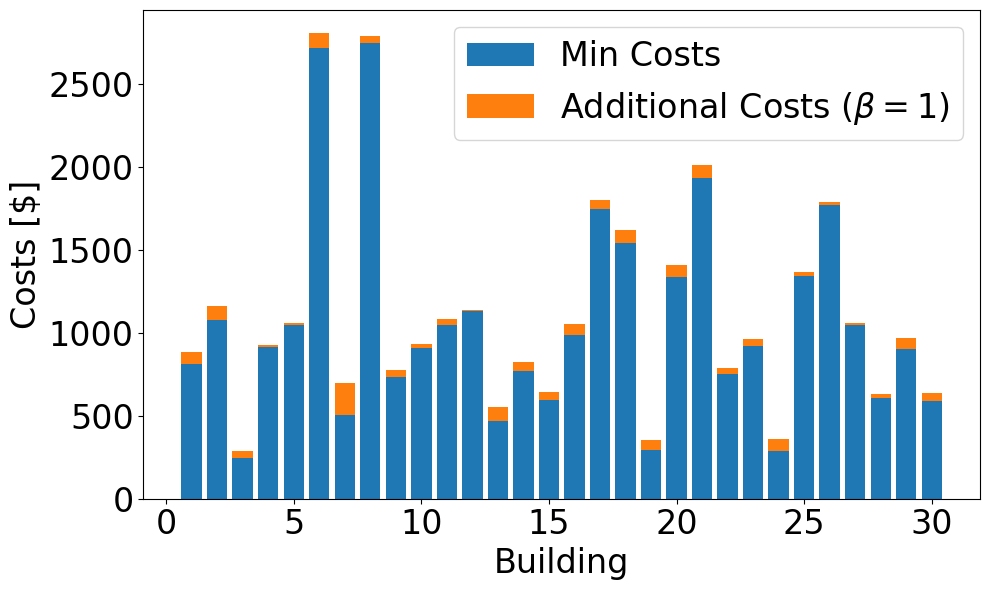

In [40]:
# Grouping by Building and Tradeoff, then calculating the mean Total Profit
mean_profit_per_building = combined_df.groupby(['Building', 'Tradeoff'])['Total Profit'].mean().unstack()

# Find the tradeoff that gives the minimum mean Total Profit for each building
min_profit = mean_profit_per_building.min(axis=1)

# Find the corresponding tradeoff values that provide this minimum mean Total Profit
min_profit_tradeoffs = mean_profit_per_building.idxmin(axis=1)

# Calculate the additional profit for other tradeoffs by subtracting the minimum profit
additional_profit = mean_profit_per_building.max(axis=1) - min_profit

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the lowest mean Total Profit as the base bar
ax.bar(min_profit.index, min_profit, label='Min Costs')

# Plotting the additional profit as the stacked bar
ax.bar(min_profit.index, additional_profit, bottom=min_profit, label=r'Additional Costs ($\beta = 1$)')

# Adding labels and title
ax.set_xlabel('Building', fontsize=24)
ax.set_ylabel('Costs [$]', fontsize=24)
ax.legend(fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Displaying the plot
plt.tight_layout()
plt.show()

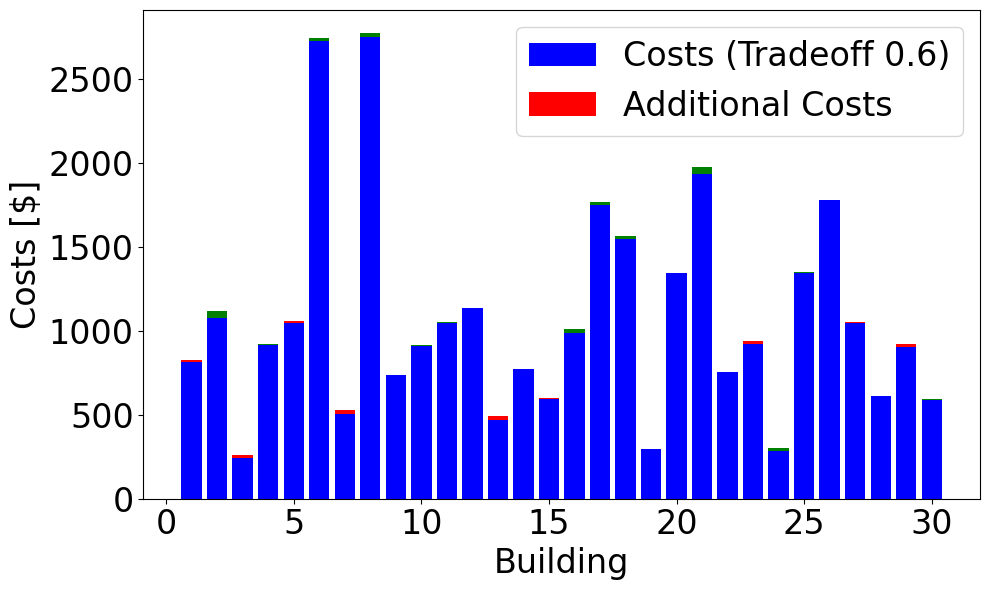

In [57]:
# Define the selected tradeoff
selected_tradeoff = "0.6"  # Replace this with your desired tradeoff value

# Grouping by Building and Tradeoff, then calculating the mean Total Profit
mean_profit_per_building = combined_df.groupby(['Building', 'Tradeoff'])['Total Profit'].mean().unstack()

# Calculate the selected tradeoff profit and tradeoff 1.0 profit
selected_profit = mean_profit_per_building[selected_tradeoff]
tradeoff_1_profit = mean_profit_per_building["1.0"]

# Calculate the difference between the selected tradeoff and tradeoff 1.0
difference_profit = tradeoff_1_profit - selected_profit

# Determine the color based on whether the difference is positive or negative
colors = ['green' if diff > 0 else 'red' for diff in difference_profit]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the selected tradeoff profit as the base bar
ax.bar(selected_profit.index, selected_profit, label=f'Costs (Tradeoff {selected_tradeoff})', color='blue')

# Plotting the difference as the stacked bar with different colors
ax.bar(selected_profit.index, difference_profit, bottom=selected_profit, label=f'Additional Costs', color=colors)

# Adding labels and title
ax.set_xlabel('Building', fontsize=24)
ax.set_ylabel('Costs [$]', fontsize=24)
ax.legend(fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Displaying the plot
plt.tight_layout()
plt.show()

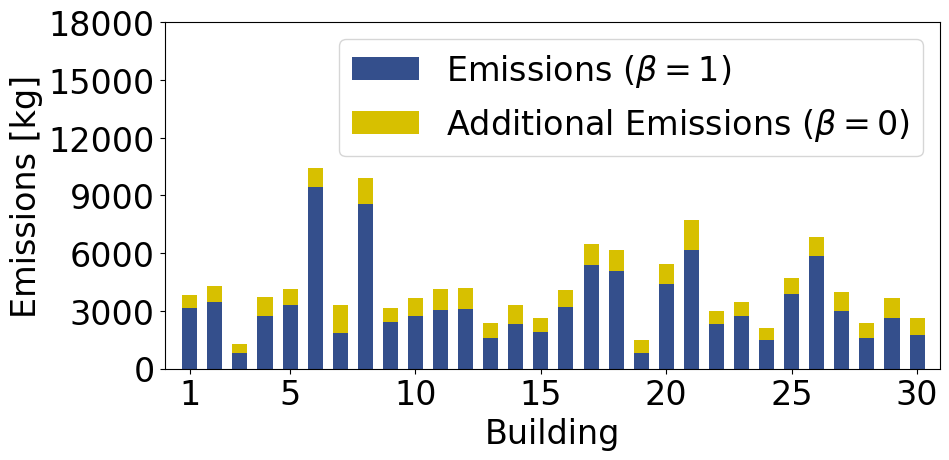

In [8]:
def load_cost_files_to_df():
    onlycosts = pd.read_csv("results/05tradeoff/FL_DDPG_TRADEOFF_Beta0.csv")
    onlyemissions = pd.read_csv("results/05tradeoff/FL_DDPG_TRADEOFF_Beta1.csv")

    data = pd.DataFrame()
    data[["Building", "Emissions0"]] = onlycosts[["Building", "Total Emissions"]]
    data["Emissions1"] = onlyemissions["Total Emissions"]

    return data

def plot_tradeoff(df_combined):
    # Convert the list of dictionaries to a DataFrame (if necessary)
    df_combined = pd.DataFrame(df_combined)
    df_combined = df_combined.groupby('Building').mean(numeric_only=True).reset_index()
    # Extract emissions data
    emissions_alpha0 = df_combined['Emissions0'].values
    emissions_alpha1 = df_combined['Emissions1'].values

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24

    # Plotting
    plt.figure(figsize=(10, 4.5))

    # Bar width
    bar_width = 0.6

    # Generate positions for the bars
    indices = np.arange(len(emissions_alpha0))

    # Plot EmissionsAlpha0 as bars
    plt.bar(indices, emissions_alpha0, bar_width, color='#294586', label=r'Emissions ($\beta = 1$)', alpha=0.95)

    # Plot EmissionsAlpha1 as stacked bars on top of EmissionsAlpha0
    plt.bar(indices, emissions_alpha1 - emissions_alpha0, bar_width, bottom=emissions_alpha0, color='#D7C000', label=r'Additional Emissions ($\beta = 0$)')

    # Adding labels and title
    plt.xlabel('Building', fontsize=font_size_labels)
    plt.ylabel('Emissions [kg]', fontsize=font_size_labels)
    plt.legend(fontsize=font_size_legend)

    # Set x-ticks to represent buildings
    buildings_labels = np.repeat(range(1, 31), 3)
    ticks = np.linspace(0, len(emissions_alpha0)-1, 7, dtype=int)
    labels = np.linspace(1, 30, 7, dtype=int)

    plt.xticks(ticks=ticks, labels=labels, fontsize=font_size_ticks)
    plt.yticks(np.arange(0, max(emissions_alpha1) + 9000, step=3000), fontsize=24)
    plt.xlim(-1, len(emissions_alpha0) - 0.1)
    # Save plot (optional)
    plt.savefig('fig/emissions_profit_tradeoff_plot.pdf', format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

# Load data and plot
combined_df = load_cost_files_to_df()
plot_tradeoff(combined_df)

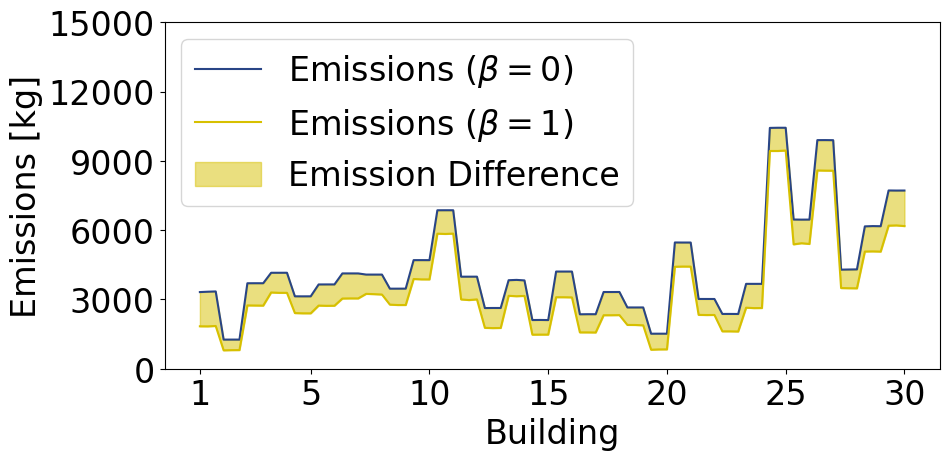

In [8]:
def load_cost_files_to_df():

    onlycosts = pd.read_csv("results/05tradeoff/FL_DDPG_TRADEOFF_Beta0.csv")
    onlyemissions = pd.read_csv("results/05tradeoff/FL_DDPG_TRADEOFF_Beta1.csv")

    data = pd.DataFrame()
    data[["Building", "Emissions0"]] = onlycosts[["Building", "Total Emissions"]]
    data["Emissions1"] = onlyemissions["Total Emissions"]

    return data


def plot_tradeoff(df_combined):
    # Convert the list of dictionaries to a DataFrame
    df_combined = pd.DataFrame(df_combined)

    # Extract emissions data
    emissions_alpha0 = df_combined['Emissions0'].values
    emissions_alpha1 = df_combined['Emissions1'].values

    # Calculate the difference between the emissions
    difference = emissions_alpha1 - emissions_alpha0

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24


    # Plotting
    plt.figure(figsize=(10, 4.5))

    # Plotting EmissionsAlpha0
    plt.plot(emissions_alpha0, label=r'Emissions ($\beta = 0$)', color='#294586')

    # Plotting EmissionsAlpha1
    plt.plot(emissions_alpha1, label=r'Emissions ($\beta = 1$)', color='#D7C000')

    # Shading the area between the lines
    plt.fill_between(range(len(emissions_alpha0)), emissions_alpha0, emissions_alpha1, color='#D7C000', alpha=0.5, label='Emission Difference')

    # Adding labels and title
    plt.xlabel('Building', fontsize=font_size_labels)
    plt.ylabel('Emissions [kg]', fontsize=font_size_labels)
    plt.legend(fontsize=font_size_legend)
    #plt.grid(True)

    # Set x-ticks to represent buildings
    buildings_labels = np.repeat(range(1, 31), 3)
    ticks = np.linspace(0, 89, 7, dtype=int)
    labels = np.linspace(1, 30, 7, dtype=int)


    plt.xticks(ticks=ticks, labels=labels, fontsize=font_size_ticks)
    plt.yticks(np.arange(0, max(emissions_alpha1) + 8000, step=3000), fontsize=24)

    # Save plot
    #plt.savefig('fig/emissions_profit_tradeoff_plot.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Load data and plot
combined_df = load_cost_files_to_df()
plot_tradeoff(combined_df)

In [54]:
max_diff_row = combined_df.loc[combined_df["Diff"].idxmax()]

display(max_diff_row)

perc = (1260.967091 -  807.291616)*100 / 1260.967091
print(perc)

Building         3.000000
Emissions0    1260.967091
Emissions1     807.291616
Diff          -453.675474
Name: 5, dtype: float64

35.978375505439736


In [56]:
min_diff_row = combined_df.loc[combined_df["Diff"].idxmin()]

display(min_diff_row)

perc = (7714.084306 -  6175.194789)*100 / 7714.084306
print(perc)

Building        21.000000
Emissions0    7714.084306
Emissions1    6175.194789
Diff         -1538.889517
Name: 89, dtype: float64

19.94908865337464


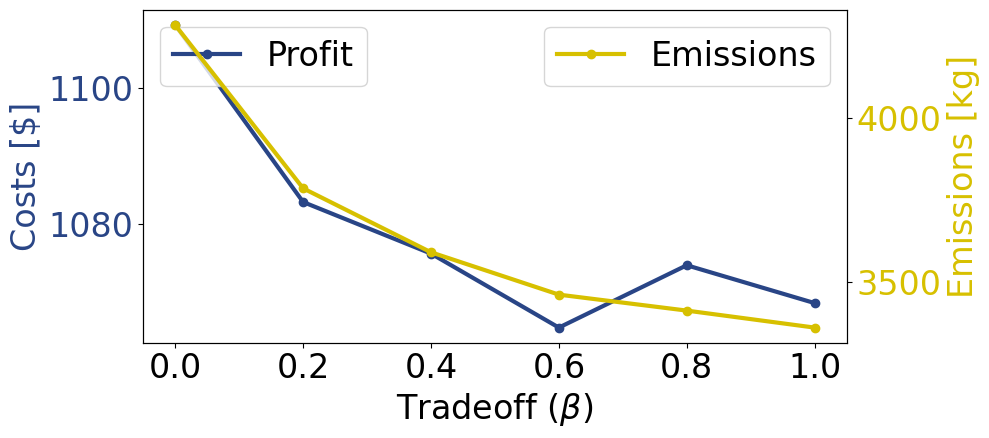

In [7]:
def load_cost_files_to_df(directory):
    # Load all CSV files from the specified directory that have 'cost' in their file name
    all_files = glob.glob(os.path.join(directory, "*tradeoff*.csv"))

    # Initialize an empty list to store individual dataframes
    data = []
    
    for file in all_files:
        df = pd.read_csv(file)
        emissions = df["Total Emissions"].mean().round(2)
        emissions_std = df.groupby("Building")["Total Emissions"].std().mean()

        profit = df["Total Profit"].mean().round(2)
        profit_std = df.groupby("Building")["Total Profit"].std().mean()

        file_prefix = os.path.basename(file).split('_')[0]

        tradeoff = re.search(r'Beta(\d+)', file)
        if tradeoff:
            tradeoff = tradeoff.group(1)
            if tradeoff == '1':
                tradeoff = '1.0'
            elif tradeoff == '0':
                tradeoff = '0.0'
            else:
                tradeoff = f'{int(tradeoff) / 10:.1f}'
        
        else:
            noise_scale = 'unknown'

        # Append the processed data
        data.append({
            'File Prefix': file_prefix,
            'Tradeoff': tradeoff,
            'Profit': profit,
            'Profit Std': profit_std,
            'Emissions': emissions,
            'Emissions Std': emissions_std
        })
    
    data = pd.DataFrame(data)
    return data

def plot_mean_profit_and_emissions_per_tradeoff(combined_df):

    # Calculate mean profit and emissions per tradeoff
    mean_profit_per_tradeoff = -combined_df.groupby('Tradeoff')['Profit'].mean()
    mean_emissions_per_tradeoff = combined_df.groupby('Tradeoff')['Emissions'].mean()

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 4.5))

    # Plotting Mean Profit
    color = '#294586'
    ax1.set_xlabel(r'Tradeoff ($\beta$)', fontsize=font_size_labels)
    ax1.set_ylabel('Costs [$]', fontsize=font_size_labels, color=color)
    ax1.plot(mean_profit_per_tradeoff.index, mean_profit_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Profit')
    ax1.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)
    ax1.tick_params(axis='x', labelsize=font_size_ticks)
    #ax1.grid(True)

    # Creating a second y-axis for Mean Emissions
    ax2 = ax1.twinx()
    color = '#D7C000'
    ax2.set_ylabel('Emissions [kg]', fontsize=font_size_labels, color=color)
    ax2.plot(mean_emissions_per_tradeoff.index, mean_emissions_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Emissions')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)

    # Adding legends
    fig.tight_layout()  # Adjust the layout to make room for the second y-axis
    ax1.legend(loc='upper left', fontsize=font_size_legend)
    ax2.legend(loc='upper right', fontsize=font_size_legend)

    # Save plot
    plt.savefig('fig/Emission_profit_tradeoff.pdf', format='pdf', bbox_inches='tight')
    plt.show()




directory = r"results/05tradeoff"
combined_df = load_cost_files_to_df(directory)

# Plot the mean profit per tradeoff
plot_mean_profit_and_emissions_per_tradeoff(combined_df)

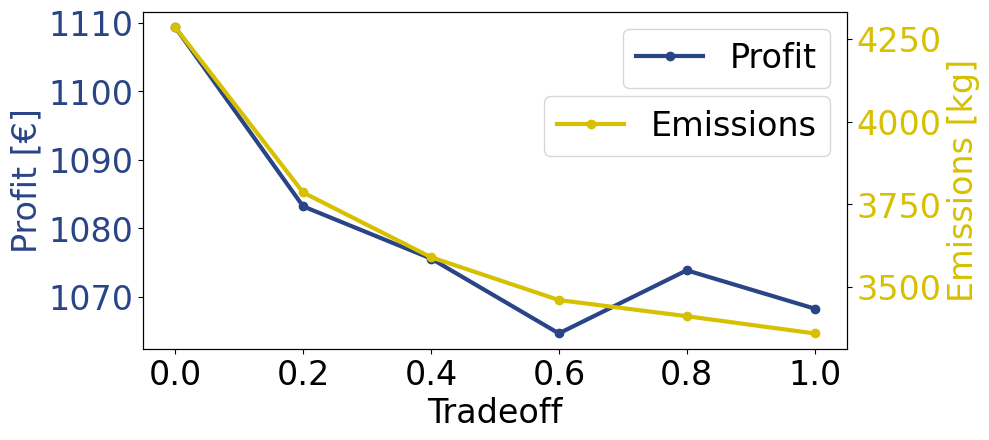

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re

def load_cost_files_to_df(directory, building=None):
    # Load all CSV files from the specified directory that have 'tradeoff' in their file name
    all_files = glob.glob(os.path.join(directory, "*tradeoff*.csv"))

    # Initialize an empty list to store individual dataframes
    data = []
    
    for file in all_files:
        df = pd.read_csv(file)
        
        if building is not None:
            df = df[df['Building'] == building]

        emissions = df["Total Emissions"].mean().round(2)
        emissions_std = df.groupby("Building")["Total Emissions"].std().mean()

        profit = -df["Total Profit"].mean().round(2)
        profit_std = df.groupby("Building")["Total Profit"].std().mean()

        file_prefix = os.path.basename(file).split('_')[0]

        tradeoff = re.search(r'Beta(\d+)', file)
        if tradeoff:
            tradeoff = tradeoff.group(1)
            if tradeoff == '1':
                tradeoff = '1.0'
            elif tradeoff == '0':
                tradeoff = '0.0'
            else:
                tradeoff = f'{int(tradeoff) / 10:.1f}'
        
        else:
            tradeoff = 'unknown'

        # Append the processed data
        data.append({
            'File Prefix': file_prefix,
            'Tradeoff': tradeoff,
            'Profit': profit,
            'Profit Std': profit_std,
            'Emissions': emissions,
            'Emissions Std': emissions_std
        })
    
    data = pd.DataFrame(data)
    return data

def plot_mean_profit_and_emissions_per_tradeoff(combined_df):

    # Calculate mean profit and emissions per tradeoff
    mean_profit_per_tradeoff = combined_df.groupby('Tradeoff')['Profit'].mean()
    mean_emissions_per_tradeoff = combined_df.groupby('Tradeoff')['Emissions'].mean()

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 4.5))

    # Plotting Mean Profit
    color = '#294586'
    ax1.set_xlabel('Tradeoff', fontsize=font_size_labels)
    ax1.set_ylabel('Profit [€]', fontsize=font_size_labels, color=color)
    ax1.plot(mean_profit_per_tradeoff.index, mean_profit_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Profit')
    ax1.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)
    ax1.tick_params(axis='x', labelsize=font_size_ticks)
    #ax1.grid(True)

    # Creating a second y-axis for Mean Emissions
    ax2 = ax1.twinx()
    color = '#D7C000'
    ax2.set_ylabel('Emissions [kg]', fontsize=font_size_labels, color=color)
    ax2.plot(mean_emissions_per_tradeoff.index, mean_emissions_per_tradeoff.values, marker='o', color=color, linewidth=3, label='Emissions')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=font_size_ticks)

    # Adding legends
    fig.tight_layout()  # Adjust the layout to make room for the second y-axis
    ax1.legend(loc='upper right', fontsize=font_size_legend, bbox_to_anchor=(1, 1))
    ax2.legend(loc='upper right', fontsize=font_size_legend, bbox_to_anchor=(1, 0.8))

    # Save plot
    plt.savefig('fig/Emission_profit_tradeoff.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Example usage
directory = r"results/05tradeoff"


combined_df = load_cost_files_to_df(directory)#, building=building_number)
plot_mean_profit_and_emissions_per_tradeoff(combined_df)


In [196]:
combined_df

,File Prefix,Tradeoff,Profit,Profit Std,Emissions,Emissions Std
0,FL,0.0,1109.33,0.301268,4285.12,2.184059
1,FL,0.2,1083.19,0.670692,3785.67,8.325794
2,FL,0.4,1075.57,0.743702,3590.07,11.312974
3,FL,0.6,1064.64,0.318628,3460.49,9.027544
4,FL,0.8,1073.85,0.602175,3411.67,8.295252
5,FL,1.0,1068.26,0.531570,3359.66,7.764919


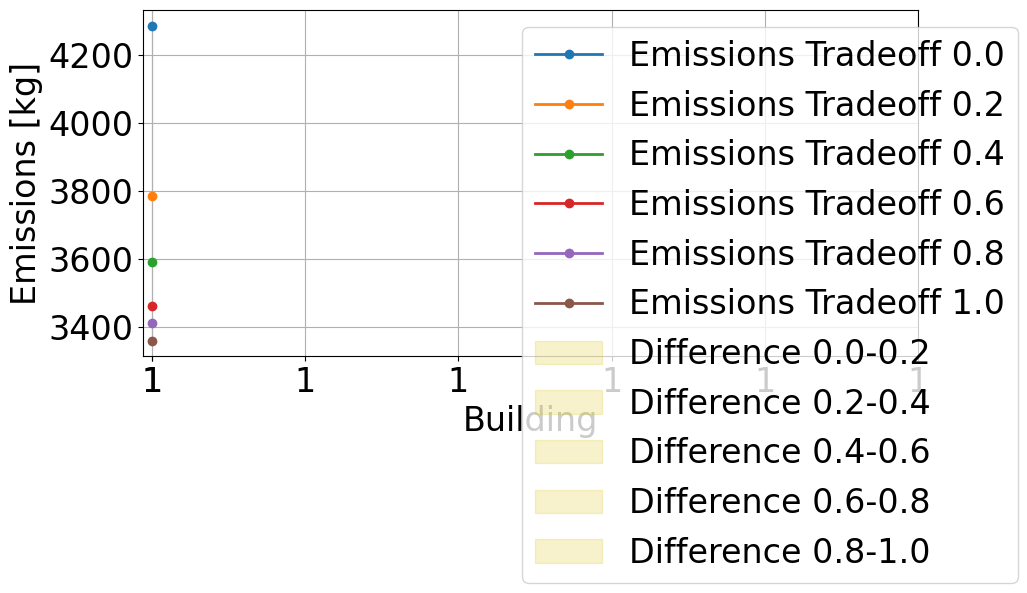

In [62]:
def load_cost_files_to_df(directory):
    # Load all CSV files from the specified directory that have 'cost' in their file name
    all_files = glob.glob(os.path.join(directory, "*tradeoff*.csv"))

    # Initialize an empty list to store individual dataframes
    data = []
    
    for file in all_files:
        df = pd.read_csv(file)
        emissions = df["Total Emissions"].mean().round(2)
        emissions_std = df.groupby("Building")["Total Emissions"].std().mean()

        profit = df["Total Profit"].mean().round(2)
        profit_std = df.groupby("Building")["Total Profit"].std().mean()

        file_prefix = os.path.basename(file).split('_')[0]

        tradeoff = re.search(r'Beta(\d+)', file)
        if tradeoff:
            tradeoff = tradeoff.group(1)
            if tradeoff == '1':
                tradeoff = '1.0'
            elif tradeoff == '0':
                tradeoff = '0.0'
            else:
                tradeoff = f'{int(tradeoff) / 10:.1f}'
        
        else:
            noise_scale = 'unknown'

        # Append the processed data
        data.append({
            'File Prefix': file_prefix,
            'Tradeoff': tradeoff,
            'Profit': profit,
            'Profit Std': profit_std,
            'Emissions': emissions,
            'Emissions Std': emissions_std
        })
    
    data = pd.DataFrame(data)
    return data

def plot_tradeoff(df_combined):
    # Extract the emissions data for each tradeoff value
    tradeoffs = df_combined['Tradeoff'].unique()
    emissions_dict = {tradeoff: df_combined[df_combined['Tradeoff'] == tradeoff]['Emissions'].values for tradeoff in tradeoffs}
    
    # Ensure the tradeoffs are sorted
    tradeoffs = sorted(tradeoffs, key=float)

    # Set font sizes
    font_size_labels = 24
    font_size_ticks = 24
    font_size_legend = 24

    # Plotting
    plt.figure(figsize=(10, 4.5))

    # Plot emissions for each tradeoff
    for tradeoff in tradeoffs:
        emissions = emissions_dict[tradeoff]
        plt.plot(emissions, marker='o', label=f'Emissions Tradeoff {tradeoff}', linewidth=2)

    # Shading the area between each consecutive pair of tradeoff emissions
    for i in range(len(tradeoffs) - 1):
        tradeoff_current = tradeoffs[i]
        tradeoff_next = tradeoffs[i + 1]
        emissions_current = emissions_dict[tradeoff_current]
        emissions_next = emissions_dict[tradeoff_next]
        plt.fill_between(range(len(emissions_current)), emissions_current, emissions_next, color='#D7C000', alpha=0.2, label=f'Difference {tradeoff_current}-{tradeoff_next}')

    # Adding labels and title
    plt.xlabel('Building', fontsize=font_size_labels)
    plt.ylabel('Emissions [kg]', fontsize=font_size_labels)
    plt.legend(fontsize=font_size_legend, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)

    # Set x-ticks to represent buildings
    num_buildings = len(df_combined) // len(tradeoffs)
    selected_ticks = np.linspace(0, len(df_combined) - 1, num=7, dtype=int)
    selected_labels = np.linspace(1, num_buildings, num=7, dtype=int)

    plt.xticks(ticks=selected_ticks, labels=selected_labels, fontsize=font_size_ticks)
    plt.yticks(fontsize=font_size_ticks)

    # Save plot
    # plt.savefig('emissions_profit_tradeoff_plot.pdf', format='pdf', bbox_inches='tight')
    plt.show()

directory = r"results/05tradeoff"
combined_df = load_cost_files_to_df(directory)
plot_tradeoff(combined_df)

In [61]:
combined_df

,File Prefix,Tradeoff,Profit,Profit Std,Emissions,Emissions Std
0,FL,0.0,-1109.33,0.301268,4285.12,2.184059
1,FL,0.2,-1083.19,0.670692,3785.67,8.325794
2,FL,0.4,-1075.57,0.743702,3590.07,11.312974
3,FL,0.6,-1064.64,0.318628,3460.49,9.027544
4,FL,0.8,-1073.85,0.602175,3411.67,8.295252
5,FL,1.0,-1068.26,0.531570,3359.66,7.764919


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'combined_dataframe' is your DataFrame

# Extract the emissions columns for EmissionsAlpha0 and EmissionsAlpha1
emissions_alpha0 = combined_dataframe['EmissionsAlpha0']
emissions_alpha1 = combined_dataframe['EmissionsAlpha1']

# Calculate the difference between the emissions
difference = emissions_alpha1 - emissions_alpha0

# Set font sizes
font_size_title = 16
font_size_labels = 16
font_size_ticks = 16
font_size_legend = 16

# Plotting
plt.figure(figsize=(10, 4.5))

# Plotting EmissionsAlpha0
plt.plot(emissions_alpha0, label='Emissions Alpha 0', color='#294586')

# Plotting EmissionsAlpha1
plt.plot(emissions_alpha1, label='Emissions Alpha 1', color='#294586')

# Shading the area between the lines
plt.fill_between(range(len(emissions_alpha0)), emissions_alpha0, emissions_alpha1, color='#D7C000', alpha=1, label='Emission Difference')

# Adding labels and title
plt.xlabel('Building', fontsize=font_size_labels)
plt.ylabel('Emissions [kg]', fontsize=font_size_labels)
plt.legend(fontsize=font_size_legend)
plt.grid(True)

# Set x-ticks to represent buildings
num_buildings = 30
building_indices = list(range(0, len(emissions_alpha0), 3))
building_labels = list(range(1, num_buildings + 1))
selected_ticks = building_indices[::5]
selected_labels = building_labels[::5]

# Ensure the first and last ticks are included
if 0 not in selected_ticks:
    selected_ticks.insert(0, 0)
    selected_labels.insert(0, 1)
if len(emissions_alpha0) - 3 not in selected_ticks:
    selected_ticks.append(len(emissions_alpha0) - 3)
    selected_labels.append(num_buildings)

plt.xticks(ticks=selected_ticks, labels=selected_labels, fontsize=font_size_ticks)
plt.yticks(fontsize=font_size_ticks)

# Show plot
#plt.savefig('emissions_profit_tradeoff_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract and sort values based on alpha
def extract_and_sort_values(row, profit_columns, emissions_columns):
    profit_values = row[profit_columns].values
    emissions_values = row[emissions_columns].values
    alpha_values = sorted([float(col.replace('ProfitAlpha', '').replace('0', '0.')) for col in profit_columns])
    sorted_profit_values = [profit for _, profit in sorted(zip(alpha_values, profit_values))]
    sorted_emissions_values = [emission for _, emission in sorted(zip(alpha_values, emissions_values))]
    return alpha_values, sorted_profit_values, sorted_emissions_values

# Extract the Profit and Emissions columns
profit_columns = [col for col in combined_dataframe.columns if col.startswith('ProfitAlpha')]
emissions_columns = [col for col in combined_dataframe.columns if col.startswith('EmissionsAlpha')]

# Extract and sort values for rows 7, 8, and 9
alpha_values_7, profit_values_7, emissions_values_7 = extract_and_sort_values(combined_dataframe.iloc[6], profit_columns, emissions_columns)
alpha_values_8, profit_values_8, emissions_values_8 = extract_and_sort_values(combined_dataframe.iloc[7], profit_columns, emissions_columns)
alpha_values_9, profit_values_9, emissions_values_9 = extract_and_sort_values(combined_dataframe.iloc[8], profit_columns, emissions_columns)

# Set font sizes
font_size = 18

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plotting Profit
color = '#294586'
ax1.set_xlabel('Alpha', fontsize=22)
ax1.set_ylabel('Profit', color=color, fontsize=22)

ax1.plot(alpha_values_7, profit_values_7, marker='o', color='#294586')
ax1.plot(alpha_values_8, profit_values_8, marker='o', color='#294586')
ax1.plot(alpha_values_9, profit_values_9, marker='o', color='#294586')

ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=font_size)

# Create a secondary y-axis for Emissions
ax2 = ax1.twinx()  
color = '#932929'
ax2.set_ylabel('Emissions', color=color, fontsize=22)

ax2.plot(alpha_values_7, emissions_values_7, marker='x', color='#932929')
ax2.plot(alpha_values_8, emissions_values_8, marker='x', color='#932929')
ax2.plot(alpha_values_9, emissions_values_9, marker='x', color='#932929')

ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=font_size)

# Add legends
profit_line = plt.Line2D([], [], color='#294586', marker='o', linestyle='None', label='Profit (Run 1-3)')
emissions_line = plt.Line2D([], [], color='#932929', marker='x', linestyle='None', label='Emissions (Run 1-3)')
ax1.legend(handles=[profit_line, emissions_line], fontsize=22, loc='center left')

#plt.savefig('Emission_profit_tradeoff_building3_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Rest

In [10]:
# Specify the directory containing the CSV files
directory_path = 'results/Figure 6 Alpha'

# List to hold all DataFrames
dataframes = []

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        # Read the CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_dataframe = pd.concat(dataframes, ignore_index=True)

# Display the combined DataFrame
combined_dataframe

,Building,Total Profit,Total Emissions,Setup
0,7,-665.597813,2948.363797,FL_DDPG_9Cluster_OnlyCost_Figure7
1,7,-662.602678,2928.485503,FL_DDPG_9Cluster_OnlyCost_Figure7
2,7,-662.619689,2930.109087,FL_DDPG_9Cluster_OnlyCost_Figure7
3,16,-1071.776245,4156.159317,FL_DDPG_9Cluster_OnlyCost_Figure7
4,16,-1071.890380,4157.577307,FL_DDPG_9Cluster_OnlyCost_Figure7
...,...,...,...,...
625,29,-991.920126,3429.609037,LL_DDPG_Alpha05_Figure6
626,29,-989.554674,3523.075846,LL_DDPG_Alpha05_Figure6
627,30,-652.743835,2566.686387,LL_DDPG_Alpha05_Figure6
628,30,-714.854587,3108.765143,LL_DDPG_Alpha05_Figure6


In [38]:
import pandas as pd
import os
import re

# Specify the directory containing the CSV files
directory_path = 'results/Figure 6 Alpha'

# Dictionary to hold DataFrames with alpha values as keys
dataframes_dict = {}

# Regex pattern to extract the alpha value from the filename
pattern = re.compile(r'Alpha(\d+\.\d+|\d+)')

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        # Extract the alpha value from the filename
        match = pattern.search(filename)
        if match:
            alpha_value = match.group(1).replace('.', '')
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            # Rename columns
            df.rename(columns={
                'Total Profit': f'ProfitAlpha{alpha_value}',
                'Total Emissions': f'EmissionsAlpha{alpha_value}'
            }, inplace=True)
            # Store DataFrame in dictionary
            dataframes_dict[alpha_value] = df

# Initialize a list to hold the columns to merge on
merge_columns = ['Building', 'Setup']

# Merge all DataFrames on 'Building' and 'Setup' columns
combined_dataframe = pd.concat(dataframes_dict.values(), axis=1)

# Drop duplicate 'Building' and 'Setup' columns that may have been introduced during concatenation
combined_dataframe = combined_dataframe.loc[:, ~combined_dataframe.columns.duplicated()]

combined_dataframe = combined_dataframe.sort_values(by='Building')
combined_dataframe.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
combined_dataframe



,Building,ProfitAlpha0,EmissionsAlpha0,Setup,ProfitAlpha01,EmissionsAlpha01,ProfitAlpha03,EmissionsAlpha03,ProfitAlpha07,EmissionsAlpha07,ProfitAlpha09,EmissionsAlpha09,ProfitAlpha1,EmissionsAlpha1,ProfitAlpha05,EmissionsAlpha05
0,1,-965.452606,4539.739202,FL_DDPG_9Cluster_OnlyCost_Figure7,-938.055363,4352.560616,-922.471755,4085.876206,-965.660931,4177.020459,-943.823898,4138.768699,-947.271351,4068.891020,-1112.957391,4073.502611
1,1,-964.804661,4534.903205,FL_DDPG_9Cluster_OnlyCost_Figure7,-939.306396,4363.138704,-919.562537,4076.897224,-966.155520,4177.983587,-940.628015,4124.290097,-952.066088,4071.226953,-1082.764155,4050.163149
2,1,-964.443114,4532.197422,FL_DDPG_9Cluster_OnlyCost_Figure7,-941.790301,4380.347783,-920.671326,4073.726800,-965.749669,4177.231958,-938.110677,4099.607861,-946.258298,4046.825006,-1096.720791,4471.771186
3,2,-1105.220288,4110.818326,FL_DDPG_9Cluster_OnlyCost_Figure7,-1109.828911,4163.180982,-1105.521195,4105.435900,-1095.438490,3902.200528,-1101.828661,3817.097765,-1112.045191,3828.225220,-874.358976,3783.387569
4,2,-1105.157440,4109.954928,FL_DDPG_9Cluster_OnlyCost_Figure7,-1109.922606,4163.845642,-1104.989129,4101.073299,-1095.385944,3901.766069,-1101.393845,3816.921275,-1111.811717,3827.712029,-858.221613,3697.963648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,29,-970.646651,3543.933005,FL_DDPG_9Cluster_OnlyCost_Figure7,-964.020699,3485.636647,-957.944493,3464.214434,-962.446736,3223.440354,-1003.262828,3105.664067,-979.540826,3042.634705,-1457.399726,5106.268571
86,29,-970.363282,3541.679634,FL_DDPG_9Cluster_OnlyCost_Figure7,-964.002942,3484.425493,-957.781728,3463.026715,-959.603441,3236.822323,-1003.264790,3105.704939,-979.291224,3046.488687,-1373.942109,4508.123263
87,30,-652.480794,2712.947078,FL_DDPG_9Cluster_OnlyCost_Figure7,-663.304252,2785.811523,-649.762011,2689.672467,-633.944639,2500.190890,-649.179220,2451.876227,-659.934906,2463.876858,-1699.463072,6839.201233
88,30,-652.546648,2713.320105,FL_DDPG_9Cluster_OnlyCost_Figure7,-663.225927,2785.295725,-650.092836,2692.109828,-633.941113,2500.388088,-648.985329,2453.055659,-662.239382,2465.902001,-1650.374132,6483.414994


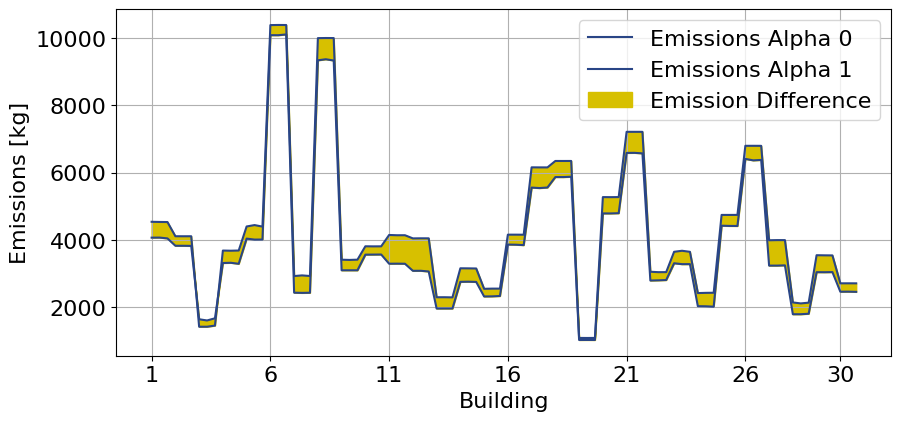

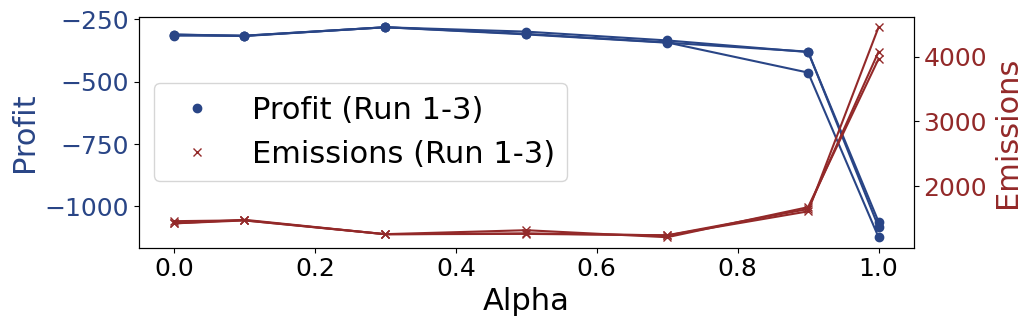